# Data Cleaning

In [116]:

import pandas as pd
import numpy as np

file_path = '/kaggle/input/void-formation-process-data-in-welding/Welding_process_parameters.csv'

data = pd.read_csv(file_path, skiprows=[1])
data = data.iloc[:, 1:]
data = data.replace(r'\*', '', regex=True)

data['Unnamed: 1'] = data['Unnamed: 1'].astype('category')

for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = pd.to_numeric(data[col], errors='coerce')

for col in data.columns:
    if data[col].dtype == 'int64':
        data[col] = data[col].astype('float64')

data = data.iloc[:, :-1]

print("DataFrame Head:")
print(data.head())
print("\nData Types of Each Column:")
print(data.dtypes)


DataFrame Head:
  Unnamed: 1  Welding speed  Rotation speed  Plate thickness  Shoulder radius  \
0       2024       0.000583           13.33            0.004             0.01   
1       2024       0.001170           13.33            0.004             0.01   
2       2024       0.002330           13.33            0.004             0.01   
3       2024       0.000583           16.67            0.004             0.01   
4       2024       0.001170           16.67            0.004             0.01   

   Axial pressure  Pin root radius  Pin tip radius  Tilt angle  \
0            13.0           0.0031          0.0009         2.0   
1            13.0           0.0031          0.0009         2.0   
2            13.0           0.0031          0.0009         2.0   
3            13.0           0.0031          0.0009         2.0   
4            13.0           0.0031          0.0009         2.0   

   Thermal diffusivity  Yield strength  Void-1 void free-0  
0              0.00005           324.0 

# Data Visualization

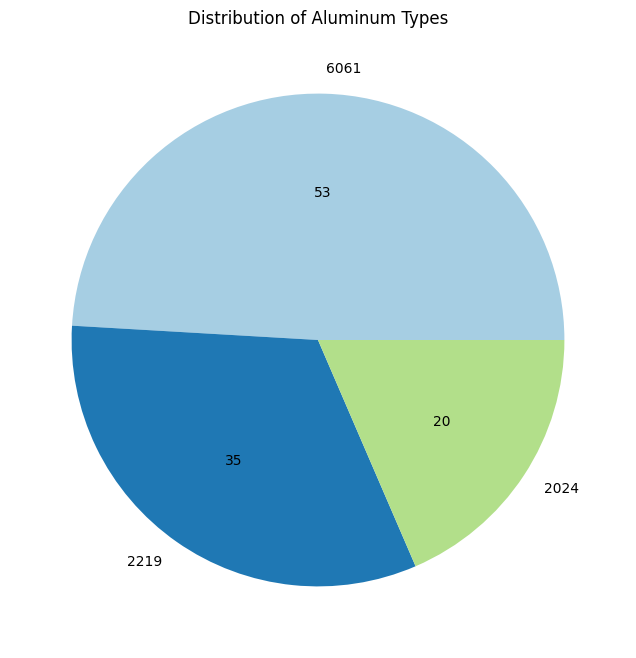

In [117]:
import matplotlib.pyplot as plt

category_counts = data['Unnamed: 1'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(category_counts, labels=category_counts.index, autopct=lambda p: '{:.0f}'.format(p * sum(category_counts) / 100), colors=plt.cm.Paired(range(len(category_counts))))
plt.title('Distribution of Aluminum Types')
plt.show()

# K-Means

In [118]:
X = data.drop(columns=['Void-1 void free-0'])
y = data['Void-1 void free-0']

X = pd.get_dummies(X, columns=['Unnamed: 1'], drop_first=True)

aluminum_type = data['Unnamed: 1']

X = data.drop(columns=['Void-1 void free-0', 'Unnamed: 1'])
X = pd.get_dummies(X, drop_first=True)

y = data['Void-1 void free-0']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=aluminum_type)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (75, 10)
X_test shape: (33, 10)
y_train shape: (75,)
y_test shape: (33,)


In [119]:
category_counts = aluminum_type.value_counts().sort_index()
category_counts = category_counts.rename("Original Count").reset_index()
category_counts.columns = ["Category", "Original Count"]

train_category_counts = aluminum_type.loc[X_train.index].value_counts().sort_index()
train_category_counts = train_category_counts.rename("Training Count").reset_index()
train_category_counts.columns = ["Category", "Training Count"]

test_category_counts = aluminum_type.loc[X_test.index].value_counts().sort_index()
test_category_counts = test_category_counts.rename("Testing Count").reset_index()
test_category_counts.columns = ["Category", "Testing Count"]

summary_table = pd.merge(category_counts, train_category_counts, on="Category", how="left")
summary_table = pd.merge(summary_table, test_category_counts, on="Category", how="left")

print("Category Counts Summary:")
print(summary_table)

Category Counts Summary:
  Category  Original Count  Training Count  Testing Count
0     2024              20              14              6
1     2219              35              24             11
2     6061              53              37             16


Class 0.0: Precision = 1.00, Recall = 0.85
Class 1.0: Precision = 0.80, Recall = 1.00
Overall F1 Score: 90.61%


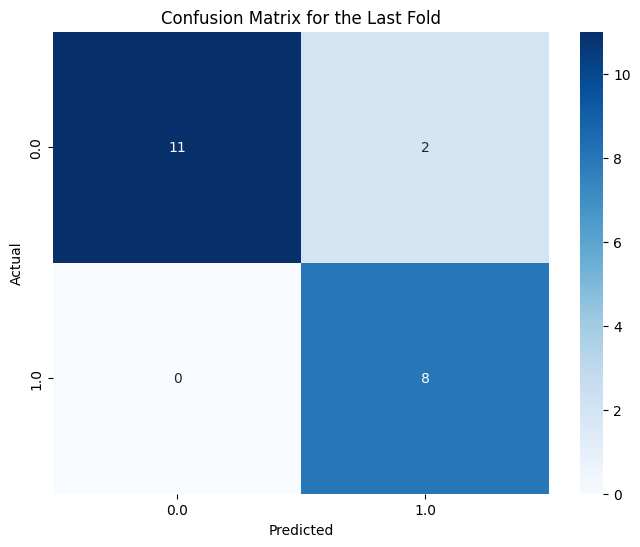

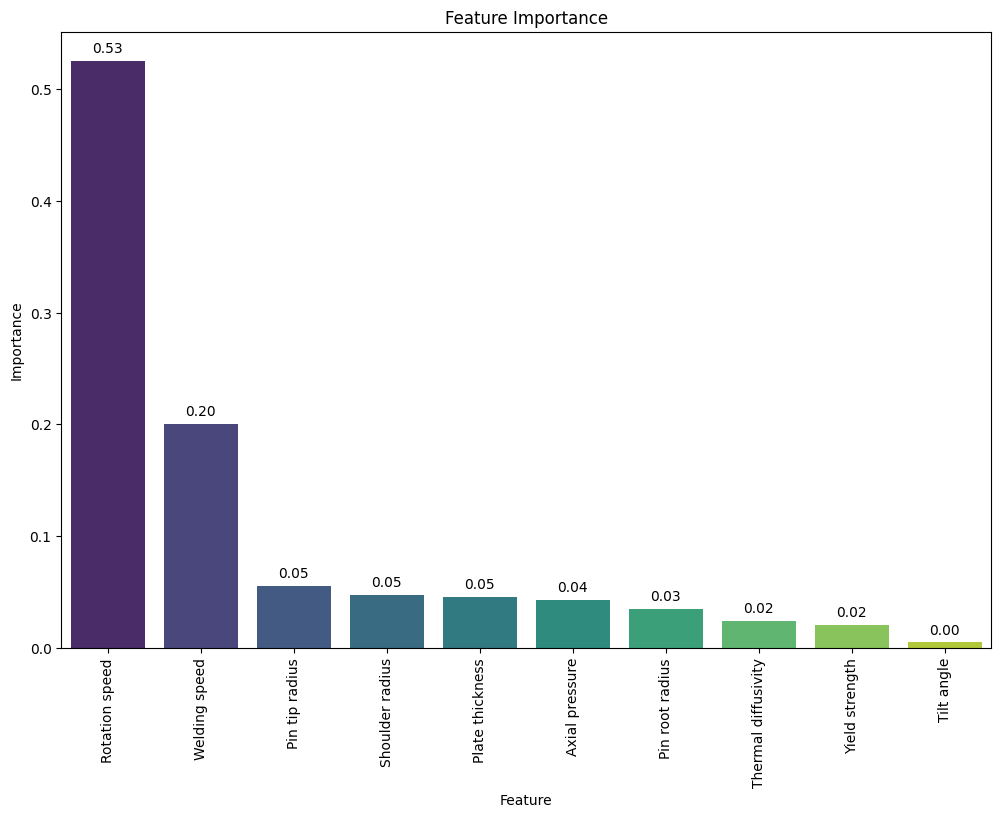

In [120]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_y_true = []
all_y_pred = []

model = RandomForestClassifier()

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    all_y_true = y_test
    all_y_pred = y_pred

last_fold_cm = confusion_matrix(all_y_true, all_y_pred)
f1 = f1_score(all_y_true, all_y_pred, average='weighted')

precision = precision_score(all_y_true, all_y_pred, average=None, labels=model.classes_)
recall = recall_score(all_y_true, all_y_pred, average=None, labels=model.classes_)

for i, label in enumerate(model.classes_):
    print(f"Class {label}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}")

print(f"Overall F1 Score: {f1 * 100:.2f}%")

plt.figure(figsize=(8, 6))
sns.heatmap(last_fold_cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for the Last Fold')
plt.show()

model.fit(X_train, y_train)  

importances = model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Feature', y='Importance', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.xticks(rotation=90)
plt.show()

# XG-Boost

Class 0: Precision = 1.00, Recall = 0.92
Class 1: Precision = 0.89, Recall = 1.00
Overall F1 Score: 95.28%


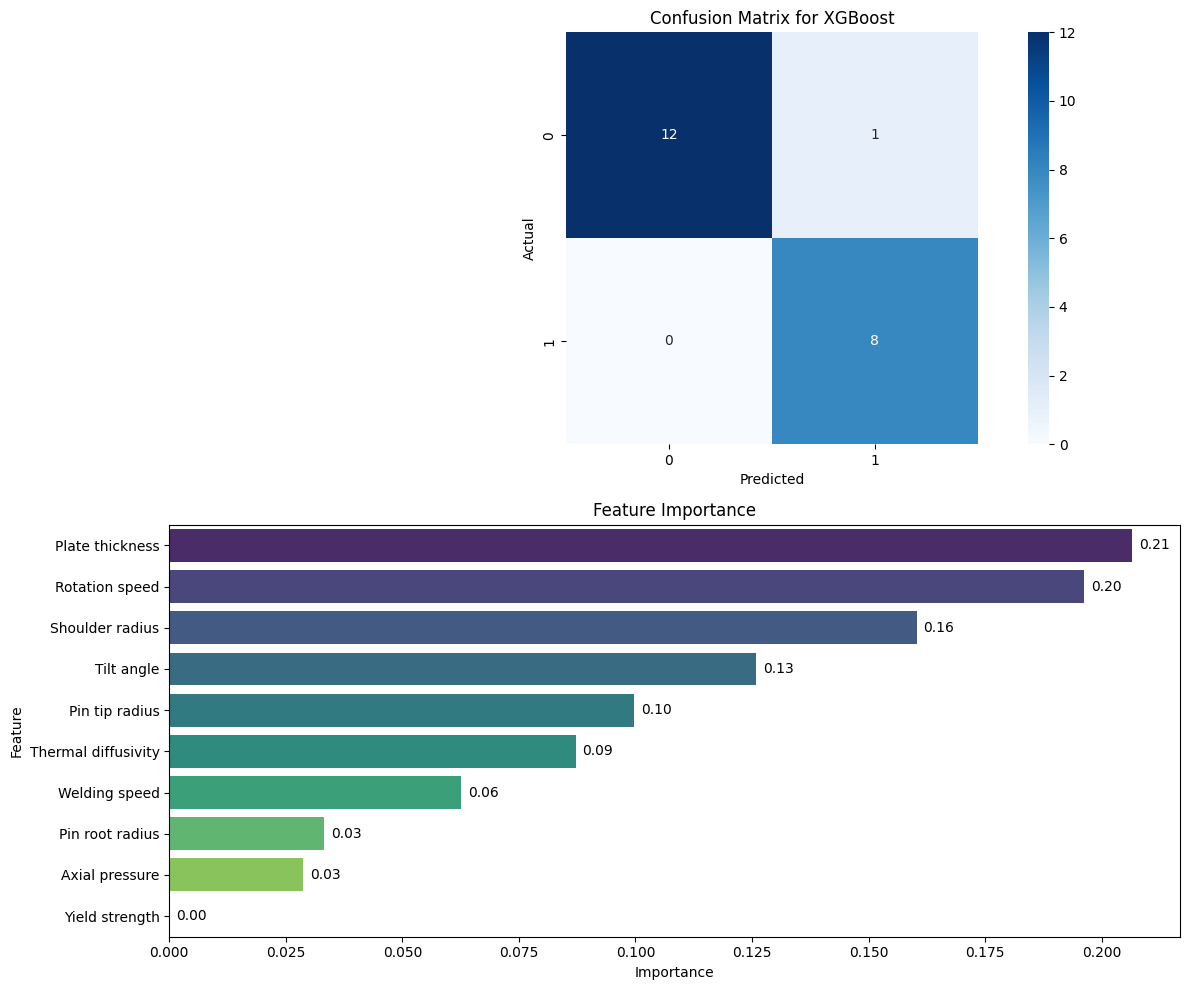

In [121]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)  

y_pred = model.predict(X_test)
all_y_true = y_test
all_y_pred = y_pred

overall_cm = confusion_matrix(all_y_true, all_y_pred)
f1 = f1_score(all_y_true, all_y_pred, average='weighted') 

precision = precision_score(all_y_true, all_y_pred, average=None, labels=model.classes_)
recall = recall_score(all_y_true, all_y_pred, average=None, labels=model.classes_)

for i, label in enumerate(model.classes_):
    print(f"Class {label}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}")

print(f"Overall F1 Score: {f1 * 100:.2f}%")

fig, axarr = plt.subplots(2, 1, figsize=(12, 10))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_, ax=axarr[0])
axarr[0].set_xlabel('Predicted')
axarr[0].set_ylabel('Actual')
axarr[0].set_title('Confusion Matrix for XGBoost')
axarr[0].set_aspect('equal')  

importances = model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', ax=axarr[1])
axarr[1].set_title('Feature Importance')
axarr[1].set_xlabel('Importance')
axarr[1].set_ylabel('Feature')

for p in axarr[1].patches:
    axarr[1].annotate(format(p.get_width(), '.2f'), 
                      (p.get_width(), p.get_y() + p.get_height() / 2.), 
                      ha='left', va='center', 
                      xytext=(5, 0), 
                      textcoords='offset points')

plt.tight_layout()  
plt.show()


# Ensemble Method (Stacking)

Class 0.0: Precision = 0.92, Recall = 0.92
Class 1.0: Precision = 0.88, Recall = 0.88
Overall F1 Score: 90.48%


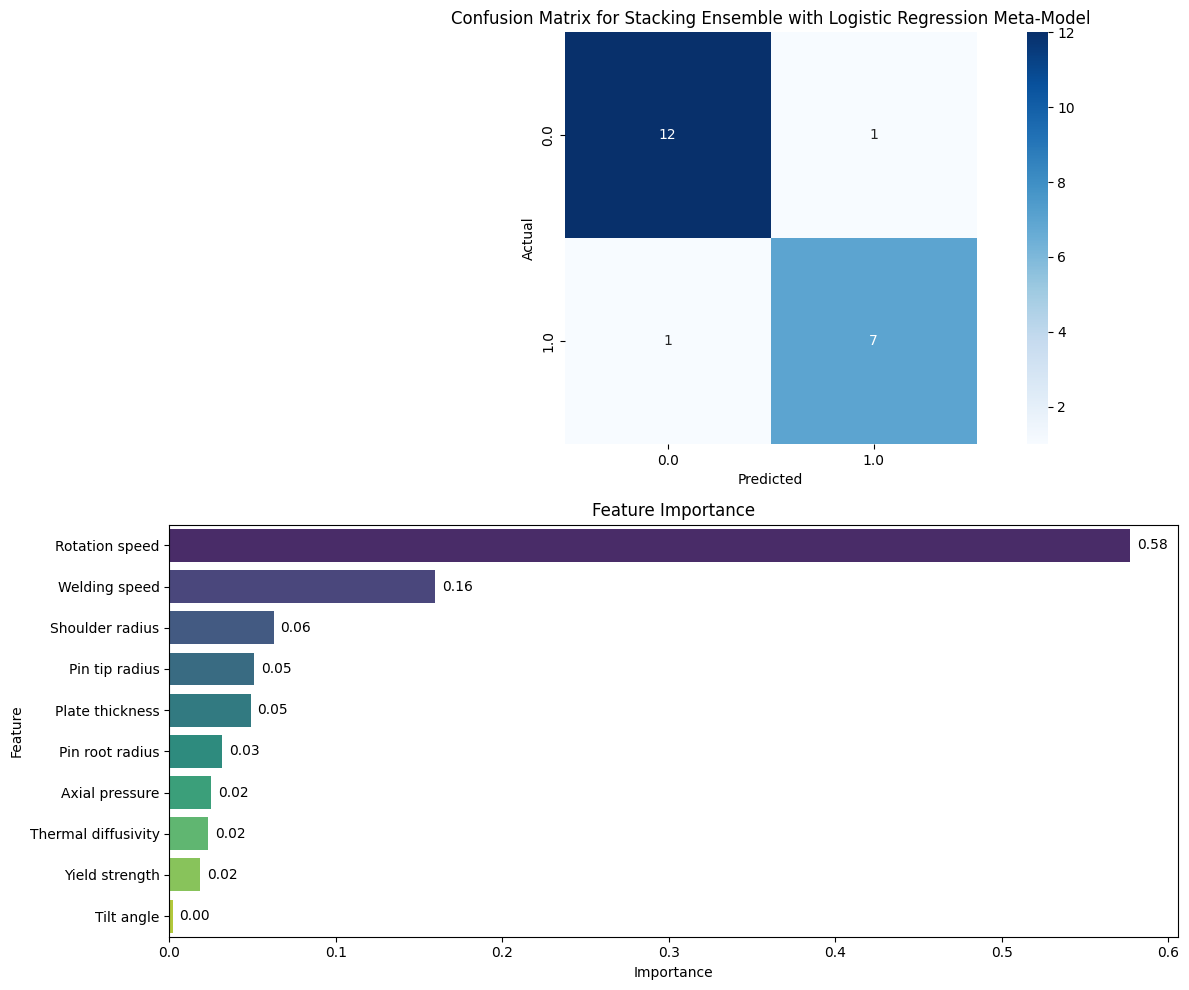

In [122]:
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)
all_y_true = y_test
all_y_pred = y_pred

overall_cm = confusion_matrix(all_y_true, all_y_pred)
f1 = f1_score(all_y_true, all_y_pred, average='weighted')  # weighted average for multi-class
precision = precision_score(all_y_true, all_y_pred, average=None, labels=stacking_model.classes_)
recall = recall_score(all_y_true, all_y_pred, average=None, labels=stacking_model.classes_)

for i, label in enumerate(stacking_model.classes_):
    print(f"Class {label}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}")

print(f"Overall F1 Score: {f1 * 100:.2f}%")

for name, model in base_models:
    model.fit(X_train, y_train)

importances = np.mean([model.feature_importances_ for name, model in base_models], axis=0)
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

fig, axarr = plt.subplots(2, 1, figsize=(12, 10))  
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues', xticklabels=stacking_model.classes_, yticklabels=stacking_model.classes_, ax=axarr[0])
axarr[0].set_xlabel('Predicted')
axarr[0].set_ylabel('Actual')
axarr[0].set_title('Confusion Matrix for Stacking Ensemble with Logistic Regression Meta-Model')
axarr[0].set_aspect('equal')  

sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', ax=axarr[1])
axarr[1].set_title('Feature Importance')
axarr[1].set_xlabel('Importance')
axarr[1].set_ylabel('Feature')

for p in axarr[1].patches:
    axarr[1].annotate(format(p.get_width(), '.2f'), 
                      (p.get_width(), p.get_y() + p.get_height() / 2.), 
                      ha='left', va='center', 
                      xytext=(5, 0), 
                      textcoords='offset points')

plt.tight_layout()
plt.show()


# Random Forest

Class 0.0: Precision = 1.00, Recall = 0.92
Class 1.0: Precision = 0.89, Recall = 1.00
Overall F1 Score: 95.28%


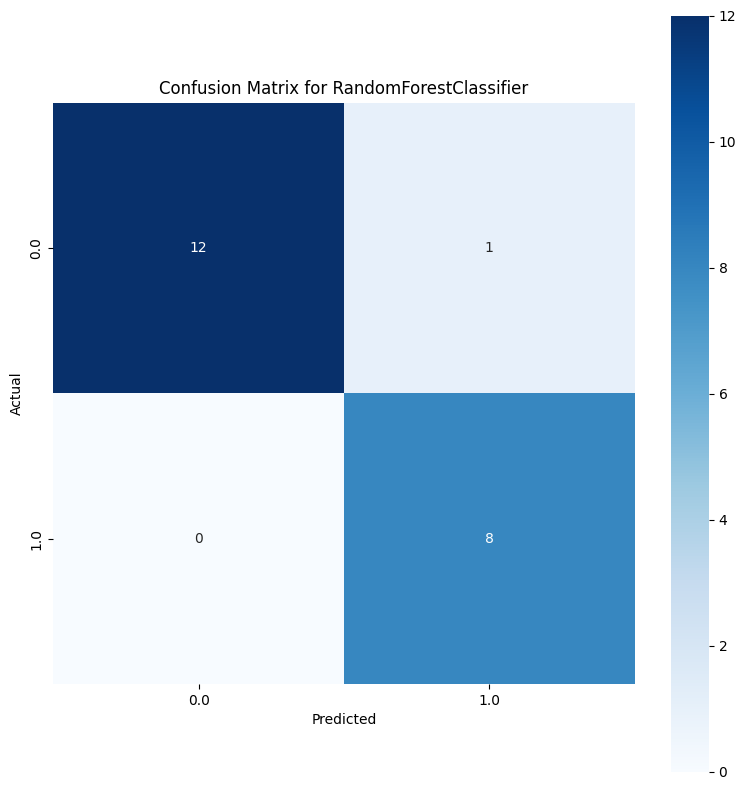

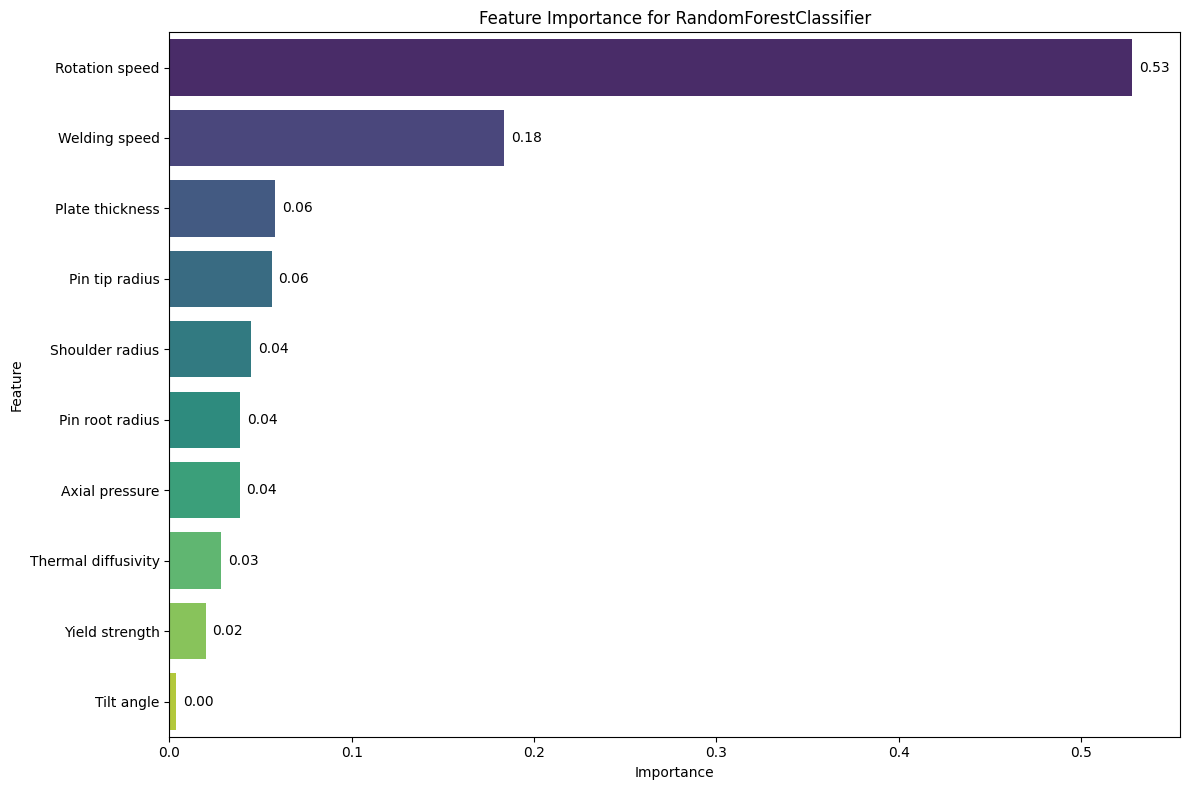

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
all_y_true = y_test
all_y_pred = y_pred

overall_cm = confusion_matrix(all_y_true, all_y_pred)
f1 = f1_score(all_y_true, all_y_pred, average='weighted')  # weighted average for multi-class

precision = precision_score(all_y_true, all_y_pred, average=None, labels=rf_model.classes_)
recall = recall_score(all_y_true, all_y_pred, average=None, labels=rf_model.classes_)

for i, label in enumerate(rf_model.classes_):
    print(f"Class {label}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}")

print(f"Overall F1 Score: {f1 * 100:.2f}%")

fig, ax = plt.subplots(figsize=(8, 8))  # Square shape
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix for RandomForestClassifier')
ax.set_aspect('equal')  # Ensure the confusion matrix is square

plt.tight_layout()
plt.show()

importances = rf_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))  # Rectangular shape
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', ax=ax)
ax.set_title('Feature Importance for RandomForestClassifier')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.2f'),
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center',
                xytext=(5, 0),
                textcoords='offset points')

plt.tight_layout()
plt.show()


# Decison Tree

Class 0.0: Precision = 0.92, Recall = 0.92
Class 1.0: Precision = 0.88, Recall = 0.88
Overall F1 Score: 90.48%


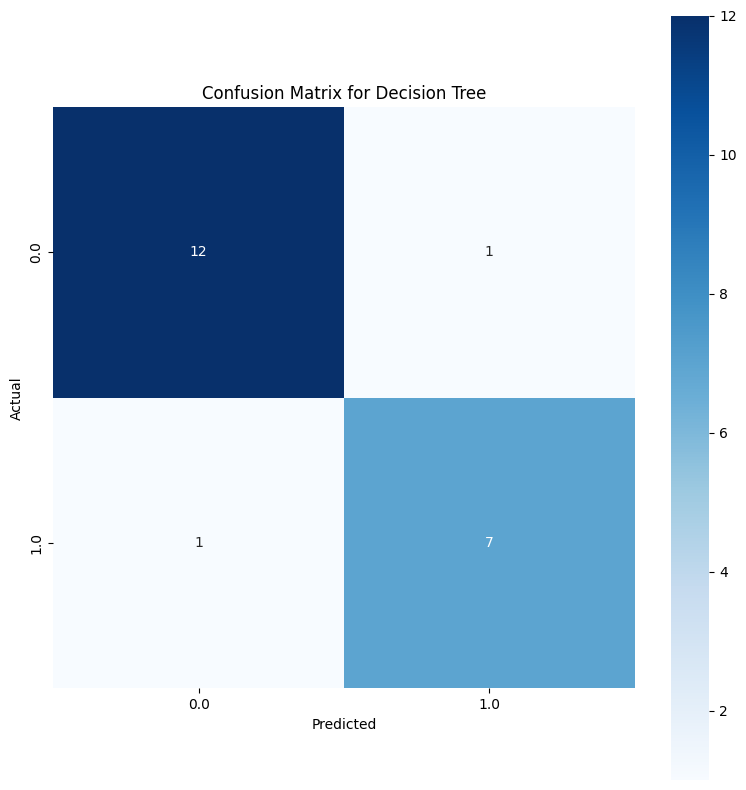

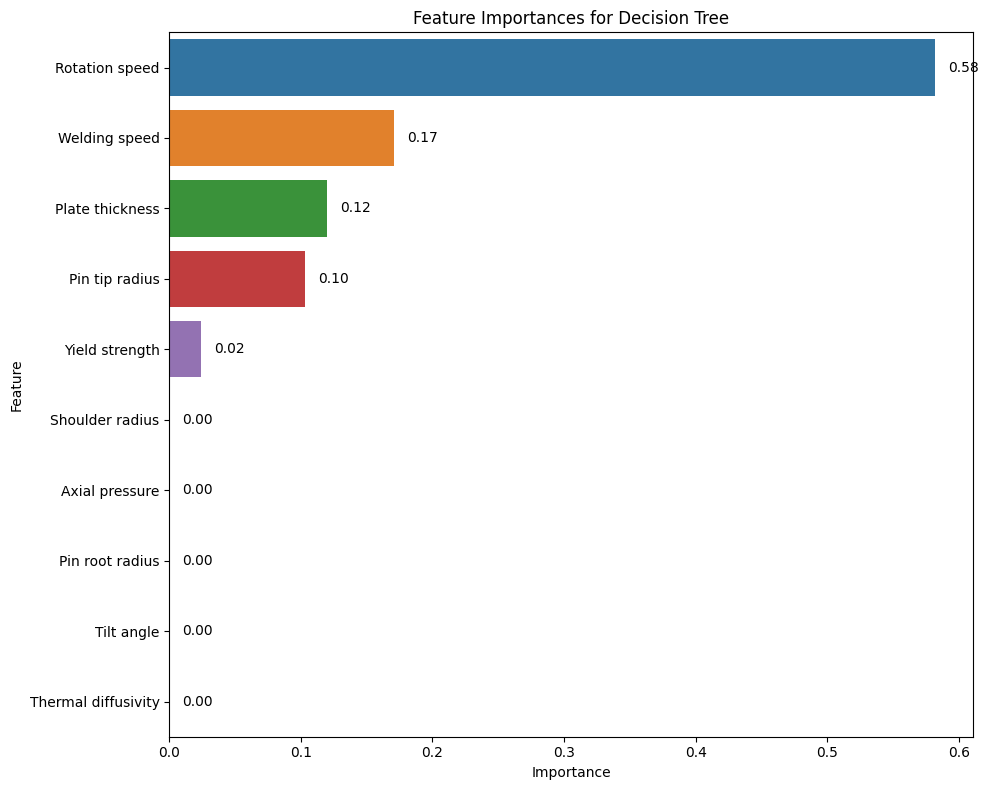

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)
all_y_true = y_test
all_y_pred = y_pred

overall_cm = confusion_matrix(all_y_true, all_y_pred)
f1 = f1_score(all_y_true, all_y_pred, average='weighted') 

precision = precision_score(all_y_true, all_y_pred, average=None, labels=dt_model.classes_)
recall = recall_score(all_y_true, all_y_pred, average=None, labels=dt_model.classes_)

for i, label in enumerate(dt_model.classes_):
    print(f"Class {label}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}")

print(f"Overall F1 Score: {f1 * 100:.2f}%")

fig, ax = plt.subplots(figsize=(8, 8))  
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues', xticklabels=dt_model.classes_, yticklabels=dt_model.classes_, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix for Decision Tree')
ax.set_aspect('equal') 

plt.tight_layout()
plt.show()

importances = dt_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))  
sns.barplot(x='Importance', y='Feature', data=importance_df, ax=ax)
ax.set_title('Feature Importances for Decision Tree')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_width() + 0.01, p.get_y() + p.get_height()/2), 
                ha='left', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()


# K Nearest Neighbour

Class 0.0: Precision = 0.80, Recall = 0.92
Class 1.0: Precision = 0.83, Recall = 0.62
Overall F1 Score: 80.27%


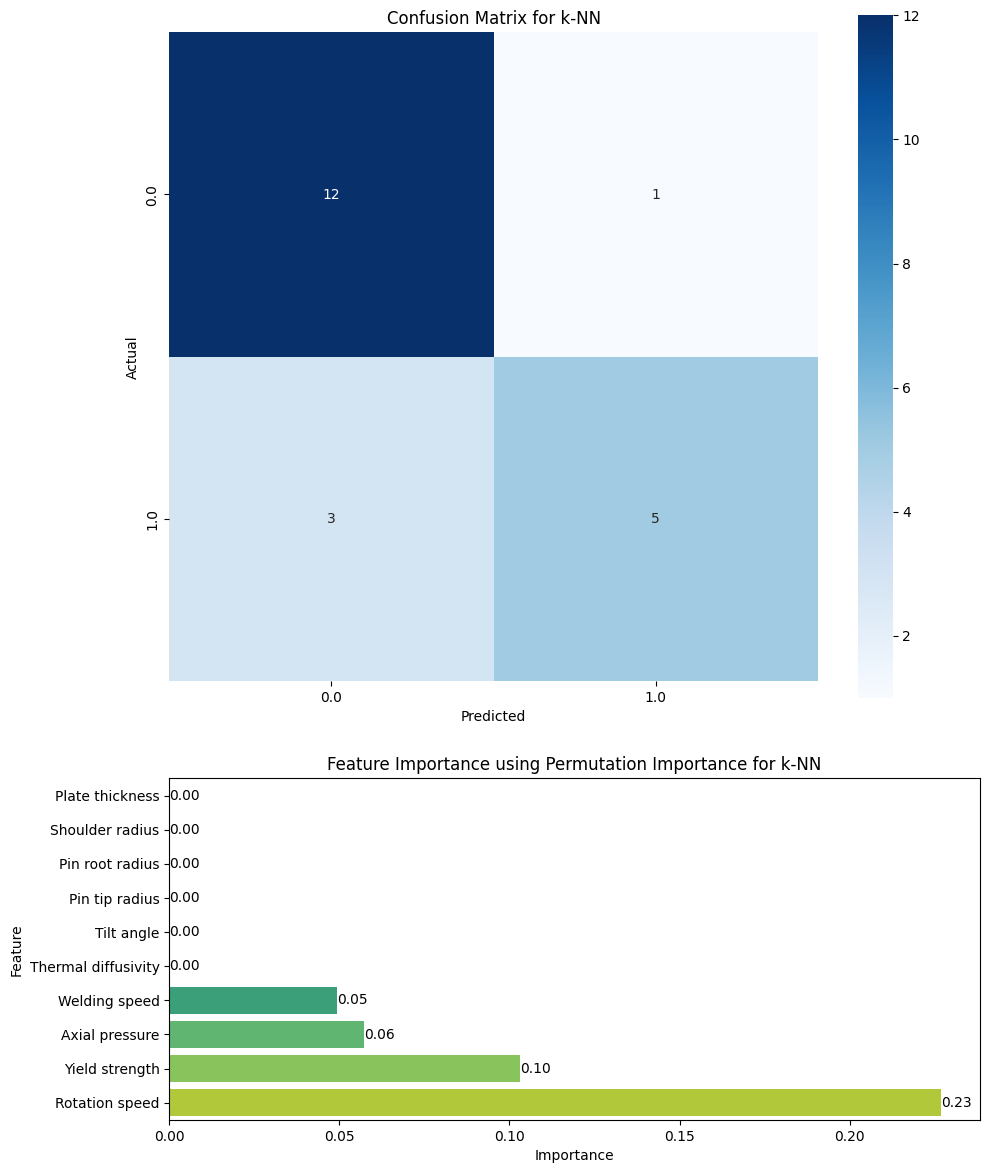

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

knn_model = KNeighborsClassifier(n_neighbors=5)  
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

overall_cm = confusion_matrix(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)

for i, label in enumerate(np.unique(y_test)):
    print(f"Class {label}: Precision = {precision[i]:.2f}, Recall = {recall[i]:.2f}")

print(f"Overall F1 Score: {f1 * 100:.2f}%")
perm_importance = permutation_importance(knn_model, X_test, y_test, n_repeats=30, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

importance_df = pd.DataFrame({
    'Feature': X.columns[sorted_idx],
    'Importance': perm_importance.importances_mean[sorted_idx]
})

fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), gridspec_kw={'height_ratios': [2, 1]})
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test), ax=axarr[0])
axarr[0].set_xlabel('Predicted')
axarr[0].set_ylabel('Actual')
axarr[0].set_title('Confusion Matrix for k-NN')
axarr[0].set_aspect('equal')  

sns.barplot(x='Importance', y='Feature', data=importance_df, ax=axarr[1], palette='viridis')
axarr[1].set_title('Feature Importance using Permutation Importance for k-NN')

for index, value in enumerate(importance_df['Importance']):
    axarr[1].text(value, index, f'{value:.2f}', va='center')

plt.tight_layout()
plt.show()
